# Firebase

In [23]:
import certifi
import os

from dotenv import load_dotenv
from pymongo import MongoClient
from pymongo.server_api import ServerApi

load_dotenv()

mongo_uri = os.environ.get("MONGO_URL")
mongo_certificate = os.environ.get("MONGO_CERTIFICATE")
client = MongoClient(mongo_uri,
                     tls=True,
                     tlsCAFile=certifi.where(),
                     tlsCertificateKeyFile=mongo_certificate,
                     server_api=ServerApi('1'))
db = client['spotifai']
track_collection = db['tracks']

limit = 1000
offset = 0
loading = True

track_data = []
query = {
    "$and": [
        {
            "tags": {
                "$ne": {
                    "$regex": "^-?[0-9]+$",
                    "$options": "m"
                }
            }
        },
        {
            "tags": {
                "$ne": "[]",
            }
        }
    ]
}

try:
    while loading:
        print("fetching tracks with offset", offset)
        docs = track_collection.find(query).skip(offset).limit(limit)
        current_track_data = [doc for doc in docs]
        loading = len(current_track_data) != 0
        track_data += current_track_data
        offset += limit
except:
    pass
print(track_data[0])

fetching tracks with offset 0
fetching tracks with offset 1000
fetching tracks with offset 2000
fetching tracks with offset 3000
fetching tracks with offset 4000
fetching tracks with offset 5000
fetching tracks with offset 6000
fetching tracks with offset 7000
fetching tracks with offset 8000
{'_id': ObjectId('63c52ec37d1543909c21dcbf'), 'id': '0Ed7MeXx64f6OcIuoTRCg1', 'name': 'Xxplosive', 'duration': 215200, 'artist_genres': ['west coast rap', 'hip hop', 'rap', 'gangster rap', 'g funk', 'hardcore hip hop', 'pop rap'], 'artist_names': ['Dr. Dre', 'Hittman', 'Kurupt', 'Nate Dogg', 'Six-Two'], 'tags': ['hip-hop', 'gangsta rap', 'west coast rap', 'hip hop', 'rap', 'west coast'], 'acousticness': 0.176, 'pitches': {'0.0': [0.159, 0.09, 0.065, 0.047, 0.099, 0.152, 0.087, 0.064, 0.107, 0.355, 1.0, 0.396], '0.20889': [0.778, 0.258, 0.125, 0.137, 0.176, 0.148, 0.121, 0.096, 0.108, 0.204, 1.0, 0.506], '0.31361': [0.024, 0.041, 0.095, 1.0, 0.261, 0.051, 0.027, 0.067, 0.021, 0.013, 0.078, 0.029], 

In [24]:
#track_collection.create_index({"id":1 },{"unique":True})

In [25]:
import pandas as pd

df = pd.DataFrame(track_data)
df.set_index("id", inplace=True)
df.info()
df = df[~df["pitches"].isna()]
tolower = lambda s: s.lower()
flatmap = lambda list_of_lists: [item for l in list_of_lists for item in l]
tags = pd.Series(flatmap(df[~df["tags"].isna()]["tags"].values.tolist())).apply(tolower).drop_duplicates()
tags.info()
tags

<class 'pandas.core.frame.DataFrame'>
Index: 7777 entries, 0Ed7MeXx64f6OcIuoTRCg1 to 3TTtBSREPFt1pOt4yJj7jD
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               7777 non-null   object 
 1   name              7777 non-null   object 
 2   duration          7777 non-null   int64  
 3   artist_genres     7777 non-null   object 
 4   artist_names      7777 non-null   object 
 5   tags              7382 non-null   object 
 6   acousticness      7776 non-null   float64
 7   pitches           7776 non-null   object 
 8   loudness          7776 non-null   float64
 9   energy            7776 non-null   float64
 10  danceability      7776 non-null   float64
 11  mode              7776 non-null   float64
 12  instrumentalness  7776 non-null   float64
 13  key               7776 non-null   float64
 14  liveness          7776 non-null   float64
 15  tempo             7776 non-null   float64
 16  time_sig

0                             hip-hop
1                         gangsta rap
2                      west coast rap
3                             hip hop
4                                 rap
                     ...             
32389                     dlo records
32390                    rock the net
32391    samanthas of the world unite
32392               make your own fun
32401                      hauntology
Length: 3427, dtype: object

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7776 entries, 0Ed7MeXx64f6OcIuoTRCg1 to 3TTtBSREPFt1pOt4yJj7jD
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               7776 non-null   object 
 1   name              7776 non-null   object 
 2   duration          7776 non-null   int64  
 3   artist_genres     7776 non-null   object 
 4   artist_names      7776 non-null   object 
 5   tags              7381 non-null   object 
 6   acousticness      7776 non-null   float64
 7   pitches           7776 non-null   object 
 8   loudness          7776 non-null   float64
 9   energy            7776 non-null   float64
 10  danceability      7776 non-null   float64
 11  mode              7776 non-null   float64
 12  instrumentalness  7776 non-null   float64
 13  key               7776 non-null   float64
 14  liveness          7776 non-null   float64
 15  tempo             7776 non-null   float64
 16  time_sig

In [27]:
df.drop_duplicates(subset=['_id'], inplace=True) # drop tracks with duplicate id

In [28]:
pitch_symbol = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]


def pitch_trans(p):
    pitch_frequency = list()
    for timestamp in p:
        pitch_dict = {"timestamp": float(timestamp)}
        for i in range(0, len(p[timestamp])):
            pitch_dict[pitch_symbol[i]] = p[timestamp][i]
        pitch_frequency.append(pitch_dict)
    return pitch_frequency


def pitches_to_dataframe(p):
    return pd.DataFrame(p).sort_values(by=["timestamp"])


pitches = df["pitches"].apply(pitch_trans)
df["pitches"] = pitches
df["pitches"]

id
0Ed7MeXx64f6OcIuoTRCg1    [{'timestamp': 0.0, 'C': 0.159, 'C#': 0.09, 'D...
10Nmj3JCNoMeBQ87uw5j8k    [{'timestamp': 0.0, 'C': 0.241, 'C#': 0.294, '...
05oETzWbd4SI33qK2gbJfR    [{'timestamp': 0.0, 'C': 1.0, 'C#': 0.817, 'D'...
66wkCYWlXzSTQAfnsPBptt    [{'timestamp': 0.0, 'C': 1.0, 'C#': 0.423, 'D'...
79H5IKTwXdAbqypigoP832    [{'timestamp': 0.0, 'C': 0.611, 'C#': 0.233, '...
                                                ...                        
0NmBSjt2Yphk4fBF0gV1Xn    [{'timestamp': 0.0, 'C': 1.0, 'C#': 0.685, 'D'...
5JpUhAcaSRVMiP6DD5MYzH    [{'timestamp': 0.0, 'C': 0.61, 'C#': 0.474, 'D...
1f8ZogeEUhm1Nv84LsoJxQ    [{'timestamp': 0.0, 'C': 0.228, 'C#': 0.248, '...
5Qz8SdojhHa5dKDF3FMD4K    [{'timestamp': 0.0, 'C': 0.992, 'C#': 0.842, '...
3TTtBSREPFt1pOt4yJj7jD    [{'timestamp': 0.0, 'C': 0.874, 'C#': 0.759, '...
Name: pitches, Length: 7776, dtype: object

In [29]:
first_song = pitches_to_dataframe(pitches.iloc[0])
first_song

,timestamp,C,C#,D,D#,E,F,F#,G,G#,A,A#,B
0,0.00000,0.159,0.090,0.065,0.047,0.099,0.152,0.087,0.064,0.107,0.355,1.000,0.396
1,0.20889,0.778,0.258,0.125,0.137,0.176,0.148,0.121,0.096,0.108,0.204,1.000,0.506
2,0.31361,0.024,0.041,0.095,1.000,0.261,0.051,0.027,0.067,0.021,0.013,0.078,0.029
3,0.53397,1.000,0.165,0.021,0.052,0.025,0.008,0.007,0.043,0.012,0.005,0.017,0.065
4,0.71982,0.658,0.512,0.431,0.327,0.247,1.000,0.252,0.238,0.059,0.077,0.073,0.541
...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,213.71048,0.168,0.193,0.544,0.677,0.397,0.694,1.000,0.464,0.583,0.198,0.232,0.138
999,214.34340,0.111,0.196,0.373,0.727,0.261,0.611,1.000,0.377,0.610,0.149,0.168,0.128
1000,214.62762,0.254,0.330,0.348,0.651,0.609,0.890,1.000,0.285,0.549,0.210,0.181,0.116
1001,214.83664,0.556,0.655,0.479,0.787,0.648,0.633,1.000,0.534,0.239,0.206,0.342,0.261


<AxesSubplot: xlabel='timestamp'>

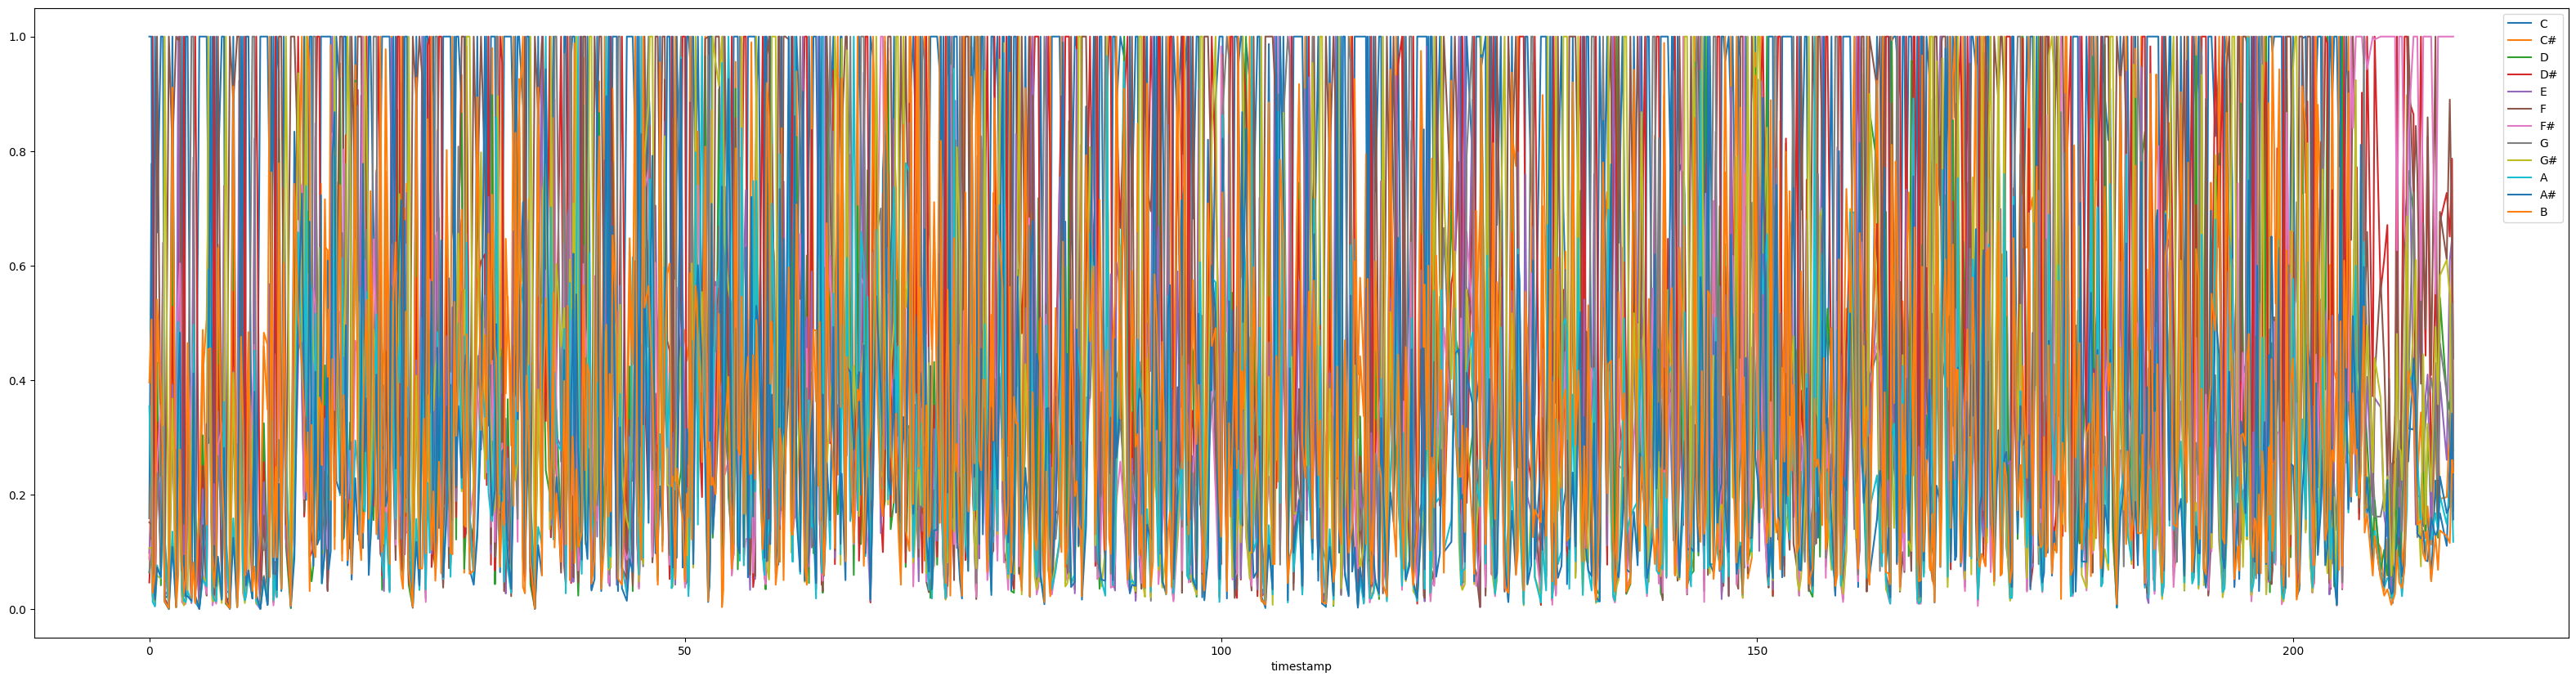

In [30]:
first_song.plot(x="timestamp", figsize=(40, 10))

In [31]:
from typing import List

from typing import Dict


def max_of_pitches(freq: List[Dict[str, float]], pitch: chr):
    return max([item[pitch] for item in freq])


def min_of_pitches(freq: List[Dict[str, float]], pitch: chr):
    return min([item[pitch] for item in freq])


for sym in pitch_symbol:
    df.insert(len(df.columns), f"{sym}_max", [max_of_pitches(item, sym) for item in df["pitches"]])
    df.insert(len(df.columns), f"{sym}_min", [min_of_pitches(item, sym) for item in df["pitches"]])
df.info()
temp_df = pd.DataFrame()

for index, row in enumerate(df["pitches"].values):
    song = pitches_to_dataframe(row)
    song["timestamp"] = song["timestamp"].apply(pd.to_timedelta, unit='s')
    resampled: pd.DataFrame = song.set_index("timestamp").resample(
        f"{song.iloc[-1]['timestamp'].total_seconds() * 10 // 1}ms").mean().interpolate()[:100]
    d: pd.DataFrame = pd.DataFrame()
    for col in resampled.columns:
        if col == "timestamp":
            continue
        d = pd.concat([d, pd.DataFrame({f"{col}_{row_idx}": [val] for row_idx, val in enumerate(resampled[col].values)},
                                       index=[df.index[index]])], axis=1)
    temp_df = pd.concat([temp_df, d])

df = pd.concat([df, temp_df], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7776 entries, 0Ed7MeXx64f6OcIuoTRCg1 to 3TTtBSREPFt1pOt4yJj7jD
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   _id               7776 non-null   object 
 1   name              7776 non-null   object 
 2   duration          7776 non-null   int64  
 3   artist_genres     7776 non-null   object 
 4   artist_names      7776 non-null   object 
 5   tags              7381 non-null   object 
 6   acousticness      7776 non-null   float64
 7   pitches           7776 non-null   object 
 8   loudness          7776 non-null   float64
 9   energy            7776 non-null   float64
 10  danceability      7776 non-null   float64
 11  mode              7776 non-null   float64
 12  instrumentalness  7776 non-null   float64
 13  key               7776 non-null   float64
 14  liveness          7776 non-null   float64
 15  tempo             7776 non-null   float64
 16  time_sig

In [32]:
df.drop(columns=["pitches"], inplace=True) # drop preprocessed pitches

In [33]:
len(df)

7776

In [34]:
df.to_csv("songs.csv", index=False)